In [ ]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; padding: 0px;}
.container {width:95% !important;}
</style>

In [1]:
%autosave 0
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from functools import partial

Autosave disabled



# Python y rendimiento | Parte 2

Python es un lenguaje versátil pero poco eficiente comparado a lenguajes de bajo nivel (C/Fortran)

Esto puede ser perjudicial si queremos usar Python para procesar una base de datos extensa o entrenar un modelo con una gran cantidad de parámetros

Sin embargo, lo que es sumamente costoso para un código escrito en "Python puro" no lo es tanto cuando usamos las librerías de cómputo científico de Python que hemos visto en este curso 

Las funciones de **Numpy**, **Scipy** y **Pandas** son eficientes porque están basadas en rutinas escritas en lenguaje C y Fortran

> La clave para lograr un alto rendimiento es usar adecuadamente las librerías

Cuando usamos estas librerías estamos usando código compilado en lugar de interpretado 

> Existen maneras de conectar nuestro código Python con código compilado escrito en lenguaje C o Fortran

En este clase veremos tres formas para mejorar el rendimiento de una rutina matemática arbitraria escrita en "Python puro":

1. Cómputo basado en arreglos con `NumPy`
1. Uniendo Python y C con `Cython`
1. Aprovechando arquitecturas multi-nucleo con `Multiprocessing`

Esto se enmarca en el contexto de **optimización de software**


## ¿Qué es la optimización de códigos/software?

Se refiere a modificar una rutina computacional para mejorar su eficiencia, es decir reducir sus

1. Tiempos de ejecución
1. Consumo de recursos 

El aspecto que se intenta modificar es aquel que limita nuestro programa 

Podemos hablar entonces de programas que están limitados en cómputo (compute-bound), limitados en memoría (memory-bound) 

La optimización puede ocurrir en distintos niveles

En el ámbito de la computación científica lo más común es enfrentar programas que están límitados... 



### ¿Por qué optimizar?



### ¿Cuándo optimizar?

`Si:` 

    tu rutina está incompleta o no entrega el resultado esperado
    
`Entonces:`

    No es momento de optimizar 


Considera que optimizar puede 
- hacer el código más complicado y menos legible 
- introducir bugs
- tomar tiempo y bastante dedicación

Por lo tanto debemos evitar optimizar de forma prematura

> Premature optimization is the root of all evil - Donald Knuth 


### ¿Dónde optimizar?

Evita gastar tiempo optimizando rutinas que influyan poco en el rendimiento total del programa

La optimización debería concentrarse en las secciones más lentas y/o costosas

Podemos encontrar dichas secciones haciendo un *profiling* de nuestro código


### 2. Haz buen uso de la sintaxis y funciones de Python

https://ipython-books.github.io/51-knowing-python-to-write-faster-code/

https://wiki.python.org/moin/PythonSpeed/PerformanceTips

http://people.duke.edu/~ccc14/sta-663-2017/10A_CodeOptimization.html


# Cómputo basado en arreglos con Numpy


Getting good performance out of code utilizing NumPy is often straightforward, asarray operations typically replace otherwise comparatively extremely slow pure Pythonloops. Here is a brief list of some of the things to keep in mind:• Convert Python loops and conditional logic to array operations and boolean arrayoperations• Use broadcasting whenever possible• Avoid copying data using array views (slicing)• Utilize ufuncs and ufunc methods



### Ejemplo: Vectorizando el cálculo del "Set de Julia"

Consideremos el código en "Python puro" que vimos en la clase de *profiling*

<IPython.core.display.Javascript object>


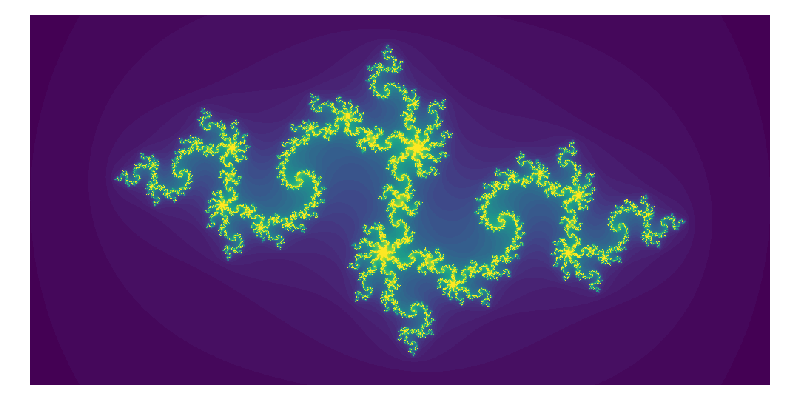

In [2]:
def evaluate(zi, zr, maxiters=50, cr=-0.835, ci=-0.2321):
    nit = 0
    zi2 = zi**2
    zr2 = zr**2
    while zi2 + zr2 <= 4. and nit < maxiters:
        zi = 2*zr*zi + ci
        zr = zr2 - zi2 + cr
        zr2 = zr**2
        zi2 = zi**2 
        nit +=1
    return nit
    
def make_fractal(N, maxiters=50):
    image = []
    for i in range(N):
        row = []
        for j in range(2*N):
            zi = -1.0 + i*2/N
            zr = -2.0 + j*2/N
            row.append(evaluate(zi, zr, maxiters))
        image.append(row)
    return image

plt.figure(figsize=(8, 4), tight_layout=True)
plt.gca().axis('off')
plt.imshow(make_fractal(500));

El tiempo total para calcular el fractal con una resolución de 500x1000 es

In [ ]:
%timeit -r3 -n1 make_fractal(500)

Estudiando el código nos damos cuenta que la función `evaluate` se ejecuta de forma secuencial para cada uno de los 500x1000 píxeles

Si guardamos la imagen y los valores de $z$ como un `ndarray` podemos actualizar todos los pixeles "al mismo tiempo"

In [74]:
def make_fractal_vectorized(N, maxiters=50):
    image = np.zeros(shape=(N, 2*N), dtype=np.int64)
    zi = np.linspace(-1, 1, num=N, endpoint=False)[:, None]
    zr = np.linspace(-2, 2, num=2*N, endpoint=False)[:, None]
    zi = np.repeat(zi, repeats=2*N, axis=1)
    zr = np.repeat(zr.T, repeats=N, axis=0)
    cr, ci = -0.835, -0.2321
    nit = 0
    while nit < maxiters:
        zr2 = zr**2
        zi2 = zi**2
        mask = zr2 + zi2 <= 4.
        image[mask] += 1
        zi[mask] = 2*zr[mask]*zi[mask] + ci
        zr[mask] = zr2[mask] - zi2[mask] +  cr
        nit += 1
    return image

np.allclose(make_fractal(500), make_fractal_vectorized(500))

True

El resultado es idéntico al código secuencial en "Python puro"

El tiempo total para calcular el fractal usando el código vectorizado es:

In [75]:
%timeit -r3 -n1 make_fractal_vectorized(500)

154 ms ± 1.06 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


El *speed-up* es el tiempo de la nueva rutina dividido el tiempo de referencia (rutina secuencial)

¿Cuánto es el *speed-up* en este caso?

#### Propuesto

En cada iteración del `while` calculamos el cuadrado de todos los $z$ 

Sin embargo lo más correcto sería calcular los cuadrados solo para los $z$ que cumplieron con la condición $|z| < 4$ la iteración anterior

Considera esta observación para optimizar aun más el código de `make_fractal_vectorized` ¿Cuánto *speed-up* obtienes?

# CPython 

La [implementación](https://wiki.python.org/moin/PythonImplementations) de Python más utilizada está escrita en C y se llama CPython

La implementación es aquello que interpreta y corre el código escrito en Python

También existen implementaciones en Java ([Jython](https://www.jython.org/)) y C# (IronPython)

CPython compila el código escrito en Python en un código de máquina (binario). Luego CPython interpreta el binario

Podemos estudiar dicho código usando el módulo [dis](https://docs.python.org/3.7/library/dis.html) de Python

In [ ]:
import dis
dis.dis(make_fractal)

# [Cython](https://cython.org/): C Extensions for Python

**Python** es un lenguaje interpretado con tipos dinámicos. Esto hace que cada operación tenga un overhead.

    z = x + y
    # overhead: Inferir el tipo de x
    # overhead: Inferir el tipo de y
    # Hacer la operación suma
    # overhead: Darle el tipo adecuado a z
    

**Cython** es un lenguaje de programación que le agrega a Python algunas propiedades de C y C++, una de ellas son los **tipos estáticos**

    int x = 1
    int y = 2
    int z = x + y
    # No hay que inferir el tipo de x, y, z

- Esto hace que Cython sea menos flexible pero decenas de veces más rápido que  Python
- En términos de sintaxis Cython es casi tan simple como Python 
- A diferencia de Python, el lenguaje Cython debe compilarse
    - El compilador de Cython convierte el código fuente en código C 
    - Luego el código C se compila como un módulo de Python con la implementación CPython

En pocas palabras
> Una vez compilado el código escrito en Cython puede llamarse desde Python!

¿Por qué considerar Cython?
- Cython es casi tan simple como Python y casi tan rápido como C
- Con Cython se pueden llamar funciones y librerías de C
- Cython se integra de buena manera con NumPy

Por ende Cython es muy atractivo para proyectos que usen Python y tengan requisitos de alto rendimiento

Estudiemos la sintaxis de Cython mediante algunos ejemplos

### Ejemplo: Distancia euclidiana todos-con-todos

Sea un conjunto de $N=1000$ datos bidimensionales ($D=2$)

Queremos calcular la distancia euclidiana de cada dato con todos los demás, es decir una matriz donde el elemento $ij$ es 

$$
\text{dist}_{ij} = \sqrt {\sum_{k=1}^D (x_{ik} - x_{jk})^2}
$$

A continuación se muestran dos códigos que cumplen este proposito y obtienen un resultado equivalente

- El primero usa "Python puro" y calcula las distancias de forma secuencial
- El segundo usa operaciones vectoriales de NumPy y calcula las distancias "al mismo tiempo"

Estudie ambos códigos hasta comprenderlos

In [4]:
data = np.random.randn(1000, 2)

def distancia_pares(data):    
    N, D = data.shape
    dist = np.empty(shape=(N, N))
    for i in range(N):
        for j in range(N):
            dist[i, j] = 0
            for k in range(D):
                dist[i, j] += (data[i, k] - data[j, k])**2
            dist[i, j] = np.sqrt(dist[i, j])
    return dist
            
def distancia_pares_numpy(data):
    return np.sqrt(np.sum((data.reshape(-1, 1, 2) - data.reshape(1, -1, 2))**2, axis=-1))

display(np.allclose(distancia_pares(data), distancia_pares_numpy(data)))
%timeit -r3 -n1 distancia_pares(data)
%timeit -r3 -n1 distancia_pares_numpy(data)

True

2.38 s ± 1.56 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
14.6 ms ± 142 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


### Cython en IPython

Ahora escribamos una versión en Cython de la función `distancia_pares`

En IPython podemos cargar la extensión `cython`

In [5]:
%load_ext cython

con esto tendremos disponible la magia de bloque `%%cython` 

- Esto hace que un bloque acepte lenguaje cython y que se compile al ejecutarlo
- Luego podremos llamar las funciones de ese bloque desde bloques regulares de Python
- Los errores de compilación aparecen como la salida del bloque
- Este bloque está "desconectado" del resto del notebook, por lo que debe tener sus propios `import`
- Opciones de magia 
    - `-a` (annotate) retorna un profile linea a linea indicando con amarillo las llamadas a CPython (mientras más llamadas más lento es nuestro código)
    - `-+` Usar C++ en lugar de C
    - `-c` Argumentos de compilación
    - `-l` librerías para linkear a nuestro código
    - `-L` directorio con librerías
    - `-I` directorio con cabeceras (include)   


In [6]:
%%cython -a

import numpy as np

def distancia_pares_cython_inocente(data):    
    N, D = data.shape
    dist = np.empty(shape=(N, N))
    for i in range(N):
        for j in range(N):
            dist[i, j] = 0.0
            for k in range(D):
                dist[i, j] += (data[i, k] - data[j, k])**2
            dist[i, j] = np.sqrt(dist[i, j])
    return dist

In [7]:
display(np.allclose(distancia_pares(data), distancia_pares_cython_inocente(data)))
%timeit -r3 -n1 distancia_pares(data)
%timeit -r3 -n1 distancia_pares_numpy(data)
%timeit -r3 -n1 distancia_pares_cython_inocente(data)

True

2.28 s ± 7.93 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
14.9 ms ± 575 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
2 s ± 9.63 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Como no hemos hecho ningún cambio el resultado solo es levemente mejor que la versión en Python puro

El primer paso para ganar rendimiento es usar [**tipos estáticos** para las variables y las funciones](https://cython.readthedocs.io/en/latest/src/quickstart/cythonize.html)

### Definiendo tipos en Cython

En Cython se definen tipos estáticos con el keyword `cdef` seguido del tipo y luego el nombre 

Por ejemplo una variable de tipo `double` llamada `mi_variable`:

    cdef double mi_variable 
    
Para los arreglos se usan ["memory-views"](https://cython.readthedocs.io/en/latest/src/userguide/memoryviews.html#memoryviews)

Por ejemplo un *memory-view* para una arreglo de tres dimensiones:

    cdef double [:, :, :] mi_arreglo
    
Puede ganarase un poco más de rendimiento especificando si el arreglo es *row-major* (estilo C)

    cdef double [:, :, ::1] mi_arreglo
    
o *column-major* (estilo Fortran)

    cdef double [::1, :, :] mi_arreglo

In [18]:
%%cython -a 

import numpy as np

def distancia_pares_cython_estatico(double [:, ::1] data):
    # Definimos el tipo de N, D, dist y data
    cdef int N = data.shape[0]
    cdef int D = data.shape[1]
    dist = np.empty(shape=(N, N), dtype=np.double)
    cdef double [:, ::1] dist_view = dist
    # También definimos los índices, se puede usar int o Py_ssize_t 
    cdef Py_ssize_t i, j, k
    for i in range(N):
        for j in range(N):
            dist_view[i, j] = 0.0
            for k in range(D):
                dist_view[i, j] += (data[i, k] - data[j, k])**2
            dist_view[i, j] = np.sqrt(dist_view[i, j])
    return dist

In [19]:
display(np.allclose(distancia_pares(data), distancia_pares_cython_estatico(data)))
%timeit -r3 -n1 distancia_pares(data)
%timeit -r3 -n1 distancia_pares_numpy(data) 
%timeit -r3 -n1 distancia_pares_cython_estatico(data)

True

2.81 s ± 21.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
14.9 ms ± 600 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
498 ms ± 13.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Con solo definir el tipo de data, dist, $N$, $D$ y los índices hemos obtenido un *speed-up* importante con respecto a "Python puro" aunque sigue siendo más lento que NumPy

Observemos el código anotado y revisemos la cantidad de llamadas a CPython de cada linea

La linea 17 es particularmente conflictiva 
- involucra una gran cantidad de instrucciones
- se llama NxN veces

esto se debe a que estamos usando la función de NumPy `np.sqrt` 

Podemos obtener un rendimiento mucho mejor si usamos la implementación de raiz cuadrada de C

### Llamando funciones de C desde Cython

Es posible llamar funciones de C desde Cython de forma sencilla

Consideremos como ejemplo la función `sqrt` de la [librería matemática estándar de C](http://pubs.opengroup.org/onlinepubs/9699919799/basedefs/math.h.html)

Necesitamos dos cosas
- Importar la función `sqrt` desde la cabecera `math.h`
    - Esto se hace con el keyword `cdef extern from`
- Compilar contra `libm`

In [24]:
%%cython -a -l m

import numpy as np

cdef extern from "math.h":
    double sqrt(double)

def distancia_pares_cython_sqrtC(double [:, ::1] data):
    # Definimos el tipo de N, D, dist y data
    cdef int N = data.shape[0]
    cdef int D = data.shape[1]
    dist = np.empty(shape=(N, N), dtype=np.double)
    cdef double [:, ::1] dist_view = dist
    # También definimos los índices, se puede usar int o Py_ssize_t 
    cdef Py_ssize_t i, j, k
    for i in range(N):
        for j in range(N):
            dist_view[i, j] = 0.0
            for k in range(D):
                dist_view[i, j] += (data[i, k] - data[j, k])**2
            dist_view[i, j] = sqrt(dist_view[i, j])
    return dist

In [26]:
display(np.allclose(distancia_pares(data), distancia_pares_cython_sqrtC(data)))
%timeit -r3 -n1 distancia_pares(data)
%timeit -r3 -n1 distancia_pares_numpy(data) 
%timeit -r3 -n1 distancia_pares_cython_estatico(data)
%timeit -r3 -n1 distancia_pares_cython_sqrtC(data)

True

2.74 s ± 1.84 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
14.7 ms ± 407 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
490 ms ± 6.11 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
2.7 ms ± 53.3 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


Con esta simple modificación hemos obtenido un tiempo de ejecución incluso menor que la implementación en NumPy


**Más importante aun:** usando `extern` podemos hacer interfaces [entre Python y casi cualquier código escrito en C](https://cython.readthedocs.io/en/latest/src/tutorial/clibraries.html)



### Deshabilitando comprobaciones para ir aun más rápido

Podemos hacer nuestro código más rápido (y más inseguro) deshabilitando las verificaciones que Python realiza por defecto

En Cython esto se hace usando decoradores que funcionan como directivas de compilación. Las opciones disponibles se encuentrán [aquí](https://cython.readthedocs.io/en/latest/src/userguide/source_files_and_compilation.html#compiler-directives)

En este caso deshabilitaremos dos verificaciones: *boundscheck* y *wraparound*

> El código no comprobará si escribimos fuera del arreglo y tampoco traducirá índices negativos

También aprovecharemos de hacer un cambio menor que nos será de utilidad más adelante:
- Definiremos el tipo de data y dist de forma más conveniente usando `ctypedef`
- Para esto incluiremos un modulo de Cython llamado numpy usando `cimport` que contiene definiciones tipo C   

In [58]:
%%cython -a -l m
import cython
cimport numpy as npc
import numpy as np

# Por conveniencia podemos definir el tipo de data y dist con 
ctypedef npc.float64_t TIPO_t
TIPO = np.float64

cdef extern from "math.h":
    TIPO_t sqrt(TIPO_t)

# Deshabilitamos las comprobaciones de Python:
@cython.boundscheck(False)
@cython.wraparound(False)
def distancia_pares_cython(TIPO_t [:, ::1] data):
    cdef int N = data.shape[0]
    cdef int M = data.shape[1]
    dist = np.empty(shape=(N, N), dtype=TIPO)
    cdef TIPO_t [:, ::1] dist_view = dist
    cdef Py_ssize_t i, j, k
    for i in range(N):
        for j in range(N):
            dist_view[i, j] = 0.0
            for k in range(M):
                dist_view[i, j] += (data[i, k] - data[j, k])**2
            dist_view[i, j] = sqrt(dist_view[i, j])
    return dist

In [59]:
display(np.allclose(distancia_pares(data), distancia_pares_cython(data)))
%timeit -r3 -n1 distancia_pares(data)
%timeit -r3 -n1 distancia_pares_numpy(data) 
%timeit -r3 -n1 distancia_pares_cython_incompleto(data)
%timeit -r3 -n1 distancia_pares_cython_sqrtC(data)
%timeit -r3 -n1 distancia_pares_cython(data)

True

2.87 s ± 10.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
14.7 ms ± 381 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
500 ms ± 934 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
2.77 ms ± 58 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
1.76 ms ± 20.4 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


Un leve speed-up "casi gratis"

### Mayor flexibilidad con tipos de Cython fusionados 

En este momento es importante recordar lo que hemos perdido con Cython: **Flexibilidad**

Si usamos un argumento que no sea `double` nuestra función en Cython retornará un error

Es nuestra responsabilidad evitar que esto ocurra

In [57]:
display("La función funciona para tipo: ", data.dtype)
data_float32 = data.astype(np.float32)
display("Pero retorna un error si la ejecutamos con", data2.dtype)
distancia_pares_cython(data_float32)

'La función funciona para tipo: '

dtype('float64')

'Pero retorna un error si la ejecutamos con'

dtype('float32')

ValueError: Buffer dtype mismatch, expected 'TIPO_t' but got 'float'

Podemos aliviar este problema usando la definición de tipos fusionado de Cython

    ctypedef fused NOMBRE:

En esta caso modificaremos la función `distancia_pares_cython` para que acepte los tipos double e float

"Por debajo" Cython creará dos funciones en lugar de una

No hay que olvidar importar la definición de `sqrtf` de `math.h`

In [71]:
%%cython -a -l m
import cython
cimport numpy as npc
import numpy as np

# Tipo fusionado
ctypedef fused TIPO_t:
    npc.float32_t
    npc.float64_t
    
cdef extern from "math.h":
    npc.float32_t sqrtf(npc.float32_t)
    npc.float64_t sqrt(npc.float64_t)

# Deshabilitamos las comprobaciones de Python:
@cython.boundscheck(False)
@cython.wraparound(False)
def distancia_pares_cython_multitipo(TIPO_t [:, ::1] data):
    cdef int N = data.shape[0]
    cdef int M = data.shape[1]
    # Comprobamos el tipo antes de crear el arrreglo de numpy
    if TIPO_t is npc.float32_t:
        TIPO = np.float32
    else:
        TIPO = np.float64
    dist = np.empty(shape=(N, N), dtype=TIPO)
    cdef TIPO_t [:, ::1] dist_view = dist
    cdef Py_ssize_t i, j, k
    for i in range(N):
        for j in range(N):
            dist_view[i, j] = 0.0
            for k in range(M):
                dist_view[i, j] += (data[i, k] - data[j, k])**2
            if TIPO_t is npc.float32_t:
                dist_view[i, j] = sqrtf(dist_view[i, j])
            else:
                dist_view[i, j] = sqrt(dist_view[i, j])
    return dist

In [73]:
display(np.allclose(distancia_pares_numpy(data), distancia_pares_cython_multitipo(data)))
display(np.allclose(distancia_pares_numpy(data_float32), distancia_pares_cython_multitipo(data_float32)))
%timeit -r3 -n1 distancia_pares(data_float32)
%timeit -r3 -n1 distancia_pares_numpy(data_float32)
%timeit -r3 -n1 distancia_pares_cython_multitipo(data_float32)

True

True

6.11 s ± 5.31 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
12.7 ms ± 156 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
1.79 ms ± 62.6 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


El resultado usando `float` es equivalente al de NumPy

La velocidad es similar a la de `distancia_pares_cython`. La pérdida de rendimiento no es notoria

### Ejemplo: "Cythonizando" el fractal de Julia

Partiendo del código de Python puro del fractal de Julia, escribimos una versión en Cython

Recuerdemos

- Usamos `cdef` para definir las variables con tipo estático
    - También podemos usar `cdef` para definir funciones con tipo
    - Las funciones con tipo solo pueden ser llamadas por otras funciones de Cython
- Usamos `ctypedef` para definir tipos 
- Usamos `cimport` para importar otros módulos de Cython
- Usamos memory-views con el tipo adecuado para conectar con NumPy en la salida
- Deshabilitamos las comprobaciones de Python para ganar más velocidad

In [83]:
%%cython
import cython
cimport numpy as npc
import numpy as np

ctypedef npc.float64_t TIPOF_t
ctypedef npc.int64_t TIPOI_t

# Las funciones con cdef solo pueden ser llamadas desde Cython
cdef TIPOI_t evaluate_z(TIPOF_t zi, TIPOF_t zr, int maxiters=50, TIPOF_t cr=-0.835, TIPOF_t ci=-0.2321):
    cdef:
        TIPOI_t nit = 0
        TIPOF_t zi2 = zi**2
        TIPOF_t zr2 = zr**2
        
    while zi2 + zr2 <= 4. and nit < maxiters:
        zi = 2.*zr*zi + ci
        zr = zr2 - zi2 + cr
        zr2 = zr**2
        zi2 = zi**2 
        nit +=1
    return nit

# Las funciones con def pueden ser llamadas desde Python
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def make_fractal_cython(int N, int maxiters=50):
    image = np.zeros(shape=(N, 2*N), dtype=np.int64) 
    cdef:
        Py_ssize_t i, j
        TIPOI_t [:, ::1] image_view = image        
    
    for i in range(N):
        for j in range(2*N):
            image_view[i, j] = evaluate_z(-1.+i*2./N, -2.+j*2./N, maxiters)
    return image

In [84]:
np.allclose(make_fractal(500), make_fractal_cython(500))
N = 500
%timeit -r3 -n1 make_fractal(N)
%timeit -r3 -n1 make_fractal_vectorized(N)
%timeit -r3 -n1 make_fractal_cython(N)

893 ms ± 2.42 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
153 ms ± 561 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
11.5 ms ± 107 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


El resultado es idéntico al código secuencial en "Python puro" y el tiempo es considerablemente menor

Ahora podemos dibujar el fractal en mayor resolución en un tiempo razonable :)

In [ ]:
plt.figure(figsize=(10, 5), tight_layout=True)
plt.gca().axis('off')
plt.imshow(make_fractal(2000, 100));

#### Propuesto: Dibuje curvas de *speed-up* para 
- Cython vs "Python puro" 
- Cython vs Numpy 

considerando $N=10, 50, 100, 500, 1000, 5000$

## Usando Cython fuera de Jupyter

El código cython se guarda tipicamente con extensión `pyx`

Se genera un código C usando `cython` usando la opción `-3` para indicar que se usará Python 3

Luego usamos nuestro compilador de C preferido apuntando adecuadamente a las cabeceras y librerías de Python 3 (y en este caso de NumPy también)

Debemos generar una libreria compartida (shared)

In [117]:
!cython -3 fractal_cython.pyx
!gcc -I/usr/include/python3.7m/ -I/usr/lib/python3.7/site-packages/numpy/core/include/ -L/usr/lib -lm -lpython3 -fPIC -shared fractal_cython.c -o fractal_cython.so

In file included from /usr/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1822,
                 from /usr/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from fractal_cython.c:593:
/usr/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it with " \
  ^~~~~~~


Luego podemos importar la librería como un módulo de Python cualquiera

In [118]:
from fractal_cython import make_fractal_cython as make_fractal_imported
np.allclose(make_fractal_cython(500), make_fractal_imported(500))

True

In [119]:
!rm fractal_cython.c fractal_cython.so

### Otros tópicos de  Cython

- [Incluyendo código Cython en un módulo de Python](https://cython.readthedocs.io/en/latest/src/quickstart/build.html#building-a-cython-module-using-distutils)
- [Haciendo profiling de código Cython](https://cython.readthedocs.io/en/latest/src/tutorial/profiling_tutorial.html)
- [Malloc/Free en Cython](https://cython.readthedocs.io/en/latest/src/tutorial/memory_allocation.html)
- Libro [Cython: A Guide for Python Programmers](https://pythonbooks.org/cython-a-guide-for-python-programmers/)

# Compilación Just-in-time (JIT) con Numba

Tema para otra iteración

In [ ]:
from numba import jit